<a href="https://colab.research.google.com/github/reemaratnani/pneumonia-detection/blob/master/pneumonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



*   Perform transfer learning to predict pneumonia in a patient, given their x-ray data
*   Retrain the "inception v3" image classifier on the x-ray pneumonia dataset using Tensorflow+Keras



In [0]:
# Import dependencies
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import urllib.request
import seaborn as sns
import tensorflow as tf
import numpy as np
import random

# Tensorflow and Keras 
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, \
  ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight

# Some utils 
from itertools import product
from functools import partial




#Import the data

In [0]:
from google.colab import files
uploaded = files.upload()


!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.28G/2.29G [00:45<00:00, 31.8MB/s]
100% 2.29G/2.29G [00:45<00:00, 54.5MB/s]


In [0]:
!unzip chest-xray-pneumonia.zip

In [0]:
# Now let's define the path to our train, validation and test directories
dataset_path = "./chest_xray/chest_xray"

In [0]:
# We have 3 datasets: train, validation and test

train_dir = os.path.join(dataset_path, "train")
validation_dir = os.path.join(dataset_path, "val")
test_dir = os.path.join(dataset_path, "test")

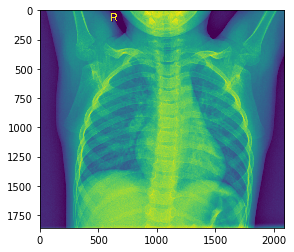

In [8]:
# Let's visualize some an example in the training set
import matplotlib.image as mpimg
example_img = mpimg.imread(train_dir + "/NORMAL/IM-0115-0001.jpeg")
plt.imshow(example_img)

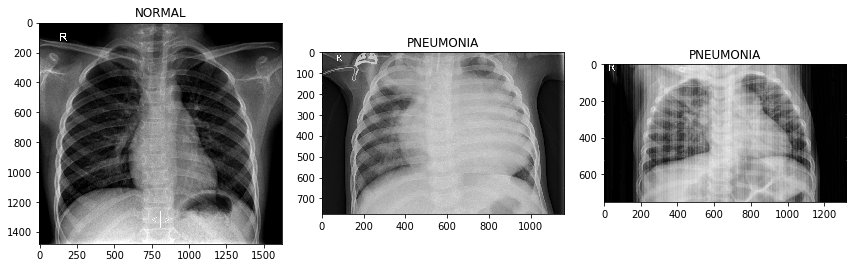

In [9]:
# Normal 
img_normal = plt.imread(f'{train_dir}/NORMAL/IM-0764-0001.jpeg')
# Bacterial
img_penumonia_bacteria = plt.imread(f'{train_dir}/PNEUMONIA/person5_bacteria_19.jpeg')
# Viral
img_penumonia_virus = plt.imread(f'{train_dir}/PNEUMONIA/person1224_virus_2074.jpeg')

# Plot Configuration
plt.figure(figsize=(12, 5))
plt.subplot(1,3,1).set_title('NORMAL')
plt.imshow(img_normal, cmap='gray')
plt.subplot(1,3,2).set_title('PNEUMONIA')
plt.imshow(img_penumonia_bacteria, cmap='gray')
plt.subplot(1,3,3).set_title('PNEUMONIA')
plt.imshow(img_penumonia_virus, cmap='gray')

plt.tight_layout()

#Building a model using Inception v3

In [10]:
# The number of classes we are trying to classify are 2
# Normal or Pneumonia
NUM_CLASSES = 2

# Build the Model
def create_model(input_shape, num_classes):
  """
  Creates the image classifier model on top of a
  pretrained Inception v3.

  Parameters
  ----------
  input_shape : Tuple    
      Shape tuple for Inception v3
  
  num_classes : Integer
      The number of classes that the classifier is 
      going to classify

  Returns
  -------
  The tensorflow model.  
  """
  # We start with a blank slate
  K.clear_session()

  # Inception v3 is our base model
  base_model = InceptionV3(weights='imagenet', include_top=False,\
                           input_shape=input_shape)
  
  # Add our custom layers on top for classification
  x = base_model.output
  x = GlobalAveragePooling2D(name='avg_pool')(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(256, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.3)(x)
  
   # We are using the base model only for feature extraction
  # So we make sure the layer weights don't change 
  for layer in base_model.layers:
    layer.trainable = False

  # The final predictions layer is going to be a dense layer
  # with Sigmoid activations - predicts only 'num_classes'    
  predictions = Dense(num_classes, activation='sigmoid')(x)
  # Instantiate the model 
  model = Model(inputs=base_model.inputs, outputs=predictions)

  return model


# Creat the model with Height & Width as 150 and 3 channels for Inception
# And we are going to predict only 2 classes in our case
model = create_model((150, 150, 3), NUM_CLASSES)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
87916544/87910968 [==============================] - 3s 0us/step


In [11]:

# Training loss
training_loss = tf.keras.metrics.Mean('training_loss', dtype=tf.float32)
# Training Accuracy
training_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    'training_accuracy', dtype=tf.float32)
# Test Loss 
test_loss = tf.keras.metrics.Mean('test_loss', dtype=tf.float32)
# Test Accuracy 
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    'test_accuracy', dtype=tf.float32)

# Print model summary 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

#Compile the model

In [0]:
# We use the standard Adam Optimizer 
optimizer = Adam(lr=0.0001)

# Compile 
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

#Feature Engineering
Augment our image dataset to ensure that we are not Overfitting

In [0]:
def dir_file_count(directory):
  """
  Counts the total number of files in a directory. 

  Parameters
  ----------
  directory : String    
      The directory isnide which the function is going
      to count the number of files 
  
  Returns
  -------
  Total number of files present inside the 'directory'.  
  """
  return sum([len(files) for r, d, files in os.walk(directory)])

In [13]:
# Configuration parameters 
rescale = 1./255
target_size = (150, 150)
batch_size = 500
class_mode = 'categorical'

# Augment the Training dataset images 
train_datagen = ImageDataGenerator(rescale=rescale,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)
# Load the images in the generator 
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=target_size,
                                                    class_mode=class_mode,
                                                    batch_size=batch_size,
                                                    shuffle=True)
# Augment the validation dataset images
val_datagen = ImageDataGenerator(rescale=rescale)
# Load the images in the generator
val_generator = val_datagen.flow_from_directory(validation_dir, 
                                                target_size=target_size,
                                                class_mode=class_mode,
                                                batch_size=dir_file_count(validation_dir),
                                                shuffle=False)
# Augment the test dataset images
test_datagen = ImageDataGenerator(rescale=rescale)
# Load the images in the generator
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=target_size,
                                                  class_mode=class_mode,
                                                  batch_size=dir_file_count(test_dir),
                                                  shuffle=False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [18]:
y = train_generator.classes
labels = np.unique(y)

train_class_weights = compute_class_weight('balanced', labels, y)
print(train_class_weights)

[1.9448173  0.67303226]


#Train the model

In [19]:
# Start the training
history = model.fit_generator(train_generator,
                              steps_per_epoch=len(train_generator),
                              epochs=10,
                              verbose=1,
                              validation_data=val_generator,
                              validation_steps=len(val_generator),
                              class_weight=train_class_weights,
                              workers=20)

# Save the model after the training is complete
MODEL_FILE = 'pneumonia_v1.hd5'
model.save(MODEL_FILE)

Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
11/11 [==============================] - 351s 32s/step - loss: 0.6222 - acc: 0.7044 - val_loss: 0.9922 - val_acc: 0.5000
Epoch 2/10
11/11 [==============================] - 282s 26s/step - loss: 0.5626 - acc: 0.7456 - val_loss: 0.7595 - val_acc: 0.5000
Epoch 3/10
11/11 [==============================] - 281s 26s/step - loss: 0.4894 - acc: 0.7625 - val_loss: 0.6787 - val_acc: 0.6250
Epoch 4/10
11/11 [==============================] - 282s 26s/step - loss: 0.4157 - acc: 0.8184 - val_loss: 0.8074 - val_acc: 0.6250
Epoch 5/10
11/11 [==============================] - 283s 26s/step - loss: 0.3694 - acc: 0.8495 - val_loss: 1.0938 - val_acc: 0.6250
Epoch 6/10
11/11 [==============================] - 283s 26s/step - loss: 0.3307 - acc: 0.8639 - val_loss: 1.2624 - val_acc: 0.6875
Epoch 7/10
11/11 [==============================] - 283s 26s/step - loss: 0.3041 - acc: 0.8758 - val_loss: 1.2676 

In [0]:
# Mount the Google Drive 
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# Move the trained model to the Google Drive 
!mv {MODEL_FILE} '/content/drive/My Drive/model'

#Evaluate the model
let's check how well model perform on testing set


In [0]:

# Load the Model from Google Drive 
MODEL_FILE = f'/content/drive/My Drive/model/{MODEL_FILE}'
model = tf.keras.models.load_model(MODEL_FILE)

In [23]:

# Run the model on Test Data 
result = model.evaluate_generator(test_generator, steps=len(test_generator),\
                                  verbose=1)

print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

1/1 [==============================] - 33s 33s/step - loss: 1.0411 - acc: 0.7228
Loss     : 1.04  
Accuracy : 72.28%


Now make the predictions on randomly choosen data in batches from test dataset. This will test the model performance on whole test dataset

In [24]:
# Randomly generate the Test Batch No
num_of_batch = len(test_generator) # This is 1 in our case 
batch_no = random.randint(0, num_of_batch - 1)

# Fetch the batch data
y_img_batch, y_true_batch = test_generator.__getitem__(batch_no)
y_true_batch = y_true_batch.argmax(axis=-1)

# Make the predictions 
y_pred_batch = model.predict(y_img_batch)
y_pred_batch = y_pred_batch.argmax(axis=-1)

# Print the results 
print("-"*35)
print("%s%d"%     ("Selected Batch No       : ", batch_no))
print("-"*35)
print("%s%d"%     ("Batch Size              : ", len(y_pred_batch)))
print("-"*35)
print("%s%.2f%s"% ("Accuracy                : ", np.mean(y_true_batch==y_pred_batch)*100, "%"))

-----------------------------------
Selected Batch No       : 0
-----------------------------------
Batch Size              : 624
-----------------------------------
Accuracy                : 72.28%
